In [3]:
import os
from datetime import datetime
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn
import pandas as pd
import json
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

Definimos los `CustomDataset` para el autoencoder, devuelve el mismo output que input (manteniendo la estructura)

In [145]:
transform = transforms.Compose([transforms.ToTensor()])

train_set = datasets.FashionMNIST("MNIST_data/", download=True, train=True, transform=transform)
valid_set = datasets.FashionMNIST("MNIST_data/", download=True, train=False, transform=transform)

class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        image, label = self.dataset[i]
        input = image
        #output = torch.flatten(image)
        return input, input
    
train_set = CustomDataset(train_set)
valid_set = CustomDataset(valid_set)

In [146]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(32*5*5, n),
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.decoder = nn.Sequential(
            nn.Linear(n, 32*5*5),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 5, 5)),
            
            nn.ConvTranspose2d(32, 16, kernel_size=(4,4), stride=(2,2), output_padding=(1,1)),
            nn.ReLU(),
            nn.Dropout(p),
            
            nn.ConvTranspose2d(16, 1, kernel_size=(3,3), stride=(2,2), output_padding=(1,1)),
            nn.Sigmoid()
            #nn.ReLU()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    
    num_batches = len(dataloader)
    sum_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        sum_loss += loss_value
        
        if batch % 100 == 0:
            print(f"batch = {batch}, loss = {loss_value}")
            
    avg_loss = sum_loss / num_batches
    return avg_loss

def valid_loop(dataloader, model, loss_fn, device="cpu"):
    model.eval()
    
    num_batches = len(dataloader)
    sum_loss = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss_value = loss_fn(pred, y).item()
            sum_loss += loss_value
    
    avg_loss = sum_loss / num_batches
    print(f"avg_loss = {avg_loss}")
    return avg_loss

Chequeamos como da el output antes de entrenar, deberia dar ruido

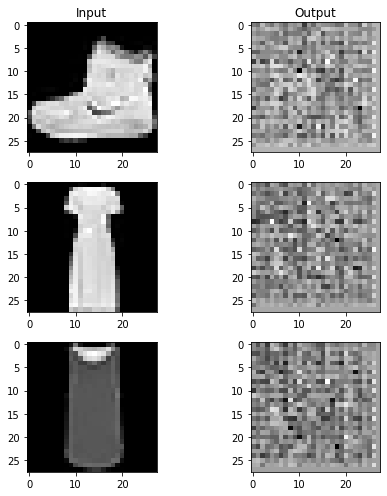

In [151]:
torch.set_num_threads(20)
model = Autoencoder(64, p=0.2)

image, _ = train_set[0]
pred = model(image.reshape(1,1,28,28))

image2, _ = train_set[50]
pred2 = model(image2.reshape(1,1,28,28))

image3, _ = train_set[2]
pred3 = model(image3.reshape(1,1,28,28))

plt.figure(figsize=(7,7))
plt.subplot(3,2,1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Input")

plt.subplot(3,2,2)
plt.imshow(pred.detach().numpy().reshape(28, 28), cmap='gray')
plt.title("Output")

plt.subplot(3,2,3)
plt.imshow(image2.squeeze(), cmap='gray')

plt.subplot(3,2,4)
plt.imshow(pred2.detach().numpy().reshape(28, 28), cmap='gray')

plt.subplot(3,2,5)
plt.imshow(image3.squeeze(), cmap='gray')

plt.subplot(3,2,6)
plt.imshow(pred3.detach().numpy().reshape(28, 28), cmap='gray')

plt.tight_layout()

Entrenamos la red con los valores optimos de batch_size, learning_rate, epochs, optimizador

In [152]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)
loss_fn = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 7
avg_loss_training_list = np.zeros(num_epochs)
avg_loss_valid_list = np.zeros(num_epochs)
avg_loss_training_inc_list = np.zeros(num_epochs)

for epoch in range(num_epochs):
    print(f"epoch = {epoch+1}/{num_epochs}")
    avg_loss_training_inc_list[epoch] = train_loop(train_loader, model, loss_fn, optimizer, device)
    avg_loss_valid_list[epoch] = valid_loop(valid_loader, model, loss_fn, device)
    avg_loss_training_list[epoch] = valid_loop(train_loader, model, loss_fn, device)

epoch = 1/7
batch = 0, loss = 0.1852269470691681
batch = 100, loss = 0.07985953986644745
batch = 200, loss = 0.061846960335969925
batch = 300, loss = 0.0576334185898304
batch = 400, loss = 0.05347182974219322
batch = 500, loss = 0.05062754824757576
avg_loss = 0.047759765014052394
avg_loss = 0.04774227724721034
epoch = 2/7
batch = 0, loss = 0.049780718982219696
batch = 100, loss = 0.046523962169885635
batch = 200, loss = 0.044670186936855316
batch = 300, loss = 0.04602987319231033
batch = 400, loss = 0.04431220889091492
batch = 500, loss = 0.04768867790699005
avg_loss = 0.04253802180290222
avg_loss = 0.0424670514340202
epoch = 3/7
batch = 0, loss = 0.04305616021156311
batch = 100, loss = 0.042609550058841705
batch = 200, loss = 0.0417555533349514
batch = 300, loss = 0.044551216065883636
batch = 400, loss = 0.03868000954389572
batch = 500, loss = 0.04011926054954529
avg_loss = 0.03921640675514936
avg_loss = 0.03911465317631761
epoch = 4/7
batch = 0, loss = 0.03795116767287254
batch = 100

0.04047023005783558


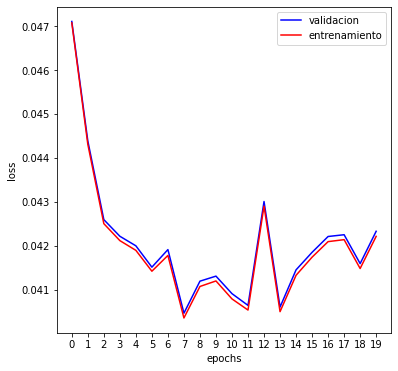

In [150]:
plt.figure(figsize=(6,6))
plt.plot(avg_loss_valid_list, c="blue")
plt.plot(avg_loss_training_list, c="red")
plt.legend(["validacion", "entrenamiento"])
#plt.plot(avg_loss_training_inc_list)
#plt.xlim([40, 80])
#plt.ylim([0.03, 0.04])
plt.ylabel("loss")
plt.xlabel("epochs")
plt.xticks(list(range(20)))

print(avg_loss_valid_list.min())

Ahora que la red esta entrenada el output deberia ser parecido al input

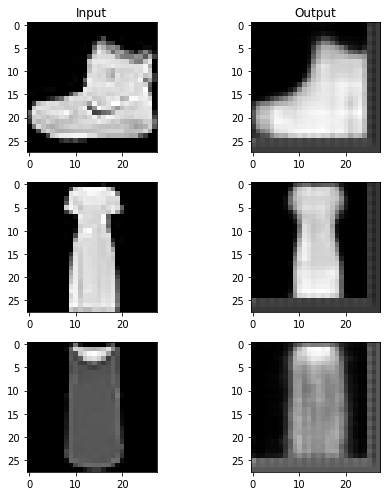

In [153]:
image, _ = train_set[0]
pred = model(image.reshape(1,1,28,28))

image2, _ = train_set[50]
pred2 = model(image2.reshape(1,1,28,28))

image3, _ = train_set[2]
pred3 = model(image3.reshape(1,1,28,28))

plt.figure(figsize=(7,7))
plt.subplot(3,2,1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Input")

plt.subplot(3,2,2)
plt.imshow(pred.detach().numpy().reshape(28, 28), cmap='gray')
plt.title("Output")

plt.subplot(3,2,3)
plt.imshow(image2.squeeze(), cmap='gray')

plt.subplot(3,2,4)
plt.imshow(pred2.detach().numpy().reshape(28, 28), cmap='gray')

plt.subplot(3,2,5)
plt.imshow(image3.squeeze(), cmap='gray')

plt.subplot(3,2,6)
plt.imshow(pred3.detach().numpy().reshape(28, 28), cmap='gray')

plt.tight_layout()

Exploramos los parametros optimos proteando el error en funcion de cada variable a ajustar

Text(0.5, 1.0, 'Loss en funcion de n')

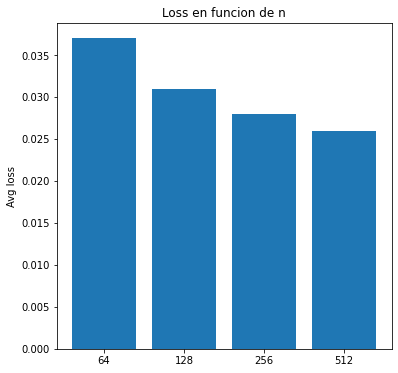

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2,3,4], [0.037, 0.031, 0.028, 0.026])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["64","128","256","512"])
ax.set_ylabel("Avg loss")
ax.set_title("Loss en funcion de n")

(0.015, 0.021)

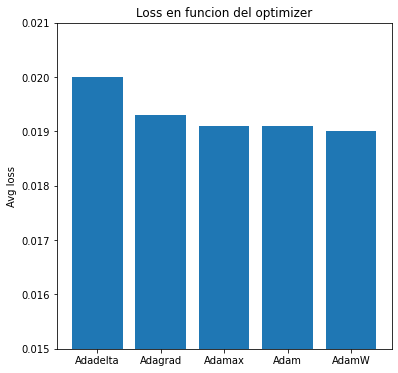

In [101]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2,3,4,5], [0.0200, 0.0193, 0.0191, 0.0191, 0.0190])
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels(["Adadelta","Adagrad", "Adamax", "Adam", "AdamW"])
ax.set_ylabel("Avg loss")
ax.set_title("Loss en funcion del optimizer")
ax.set_ylim([0.0150, 0.0210])

Text(0, 0.5, 'Loss')

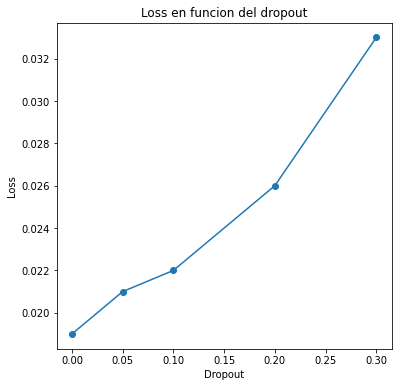

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0.0, 0.05, 0.1, 0.2, 0.3], [0.019, 0.021, 0.022, 0.026, 0.033])
ax.scatter([0.0, 0.05, 0.1, 0.2, 0.3], [0.019, 0.021, 0.022, 0.026, 0.033])
ax.set_title("Loss en funcion del dropout")
ax.set_xlabel("Dropout")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

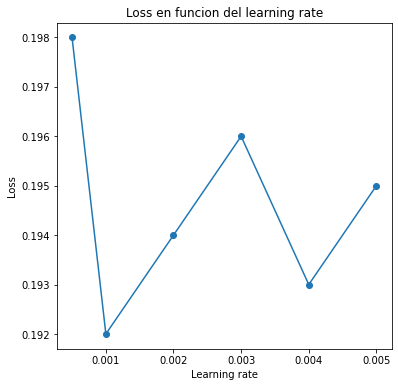

In [49]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0.0005, 0.001, 0.002, 0.003, 0.004, 0.005], [0.198, 0.192, 0.194, 0.196, 0.193, 0.195])
ax.scatter([0.0005, 0.001, 0.002, 0.003, 0.004, 0.005], [0.198, 0.192, 0.194, 0.196, 0.193, 0.195])
ax.set_title("Loss en funcion del learning rate")
ax.set_xlabel("Learning rate")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Loss')

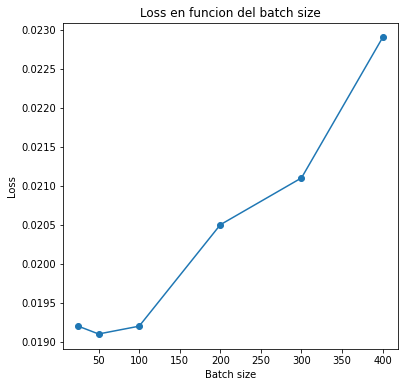

In [72]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([25, 50, 100, 200, 300,400], [0.0192, 0.0191, 0.0192, 0.0205, 0.0211, 0.0229])
ax.scatter([25, 50, 100, 200, 300, 400], [0.0192, 0.0191, 0.0192, 0.0205, 0.0211, 0.0229])
ax.set_title("Loss en funcion del batch size")
ax.set_xlabel("Batch size")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Avg loss')

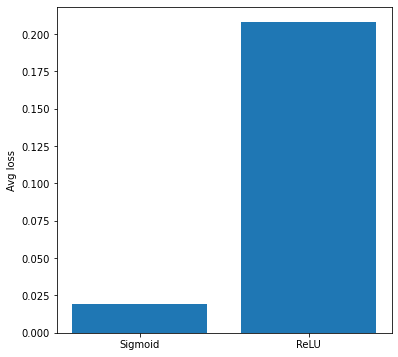

In [106]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2], [0.0190, 0.208])
ax.set_xticks([1,2])
ax.set_xticklabels(["Sigmoid","ReLU"])
ax.set_ylabel("Avg loss")

Armamos una nueva red para clasificar, usando el encoder entrenado. 
Primero hay que cargar los datos junto con los labels

In [230]:
train_set = datasets.FashionMNIST("MNIST_data/", download=True, train=True, transform=transform)
valid_set = datasets.FashionMNIST("MNIST_data/", download=True, train=False, transform=transform)
train_clas_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_clas_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)
train_clas_features, train_clas_labels = next(iter(train_clas_loader))
valid_clas_features, valid_clas_labels = next(iter(valid_clas_loader))

In [231]:
class Classifier(nn.Module):
    def __init__(self, n, encoder=None, p=0.2):
        super(Classifier, self).__init__()
        if encoder is None:
            self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(32*5*5, n),
            nn.ReLU(),
            nn.Dropout(p)
        )
        else:
            self.encoder = encoder
            
        self.classifier = nn.Sequential(
            nn.Linear(n, 10),
            nn.ReLU(),
            nn.Dropout(p)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        
        return x

def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    model.train()
    
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    sum_loss = 0
    sum_correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_value = loss.item()
        sum_loss += loss_value
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 100 == 0:
            print(f"batch = {batch}, loss = {loss_value}")
            
    avg_loss = sum_loss / num_batches
    precision = sum_correct / size
    
    return avg_loss, precision

def valid_loop(dataloader, model, loss_fn, device="cpu"):
    model.eval()
    
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    sum_loss = 0
    sum_correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            loss_value = loss_fn(pred, y).item()
            sum_loss += loss_value
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    avg_loss = sum_loss / num_batches
    precision = sum_correct / size
    print(f"avg_loss = {avg_loss}, precision = {precision}")
    
    return avg_loss, precision

In [232]:
model_clas = Classifier(64, model.encoder, p=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_clas = model_clas.to(device)
loss_clas = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer_clas = torch.optim.Adam(model_clas.classifier.parameters(), lr=learning_rate)
#optimizer_clas = torch.optim.SGD(model_clas.parameters(), lr=learning_rate)

num_epochs = 30
train_clas_loss = np.zeros(num_epochs)
valid_clas_loss = np.zeros(num_epochs)
train_clas_prec = np.zeros(num_epochs)
valid_clas_prec = np.zeros(num_epochs)
for epoch in range(num_epochs):
    print(f"epoch {epoch+1}/{num_epochs}")
    
    _, _ = train_loop(train_clas_loader, model_clas, loss_clas, optimizer_clas, device)
    train_clas_loss[epoch], train_clas_prec[epoch] = valid_loop(train_clas_loader, model_clas, loss_clas, device)
    valid_clas_loss[epoch], valid_clas_prec[epoch] = valid_loop(valid_clas_loader, model_clas, loss_clas, device)

epoch 1/30
batch = 0, loss = 2.588972568511963
batch = 100, loss = 1.5405727624893188
batch = 200, loss = 1.3811112642288208
batch = 300, loss = 1.3104976415634155
batch = 400, loss = 1.595443606376648
batch = 500, loss = 1.2792328596115112
avg_loss = 1.076485523780187, precision = 0.7738166666666667
avg_loss = 1.0932331329584122, precision = 0.7644
epoch 2/30
batch = 0, loss = 1.024726152420044
batch = 100, loss = 1.2938735485076904
batch = 200, loss = 0.999281108379364
batch = 300, loss = 1.1968622207641602
batch = 400, loss = 1.2493319511413574
batch = 500, loss = 1.253472089767456
avg_loss = 1.0034444238742193, precision = 0.7872833333333333
avg_loss = 1.0207204771041871, precision = 0.7765
epoch 3/30
batch = 0, loss = 1.3839656114578247
batch = 100, loss = 1.2034811973571777
batch = 200, loss = 1.1018184423446655
batch = 300, loss = 1.0465569496154785
batch = 400, loss = 1.029249668121338
batch = 500, loss = 1.1694027185440063
avg_loss = 0.9706051390369733, precision = 0.789866666

batch = 400, loss = 1.0023928880691528
batch = 500, loss = 1.236594557762146
avg_loss = 0.8321366864442825, precision = 0.7880666666666667
avg_loss = 0.8537408363819122, precision = 0.775
epoch 25/30
batch = 0, loss = 1.150001049041748
batch = 100, loss = 0.9179984331130981
batch = 200, loss = 1.2706624269485474
batch = 300, loss = 1.2820146083831787
batch = 400, loss = 1.3386528491973877
batch = 500, loss = 1.0979324579238892
avg_loss = 0.835897090236346, precision = 0.7824833333333333
avg_loss = 0.8584244656562805, precision = 0.7729
epoch 26/30
batch = 0, loss = 1.1063227653503418
batch = 100, loss = 0.925434410572052
batch = 200, loss = 1.3454697132110596
batch = 300, loss = 1.0004762411117554
batch = 400, loss = 1.0670219659805298
batch = 500, loss = 0.9635074138641357
avg_loss = 0.8321010995904604, precision = 0.7858
avg_loss = 0.8533522766828537, precision = 0.7781
epoch 27/30
batch = 0, loss = 1.1431182622909546
batch = 100, loss = 1.0376495122909546
batch = 200, loss = 0.87471

0.7833


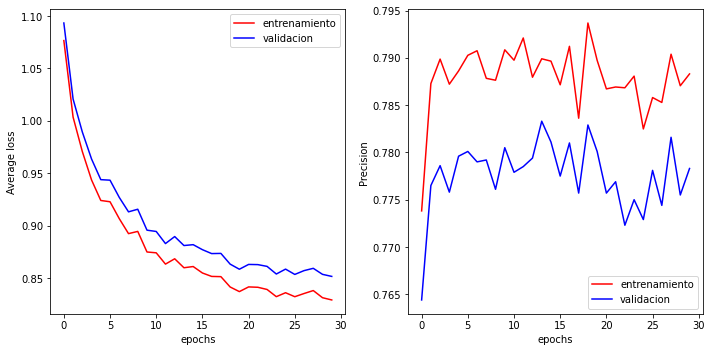

In [233]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_clas_loss, color="red")
plt.plot(valid_clas_loss, color="blue")
plt.ylabel("Average loss")
plt.xlabel("epochs")
plt.legend(["entrenamiento", "validacion"])

plt.subplot(1,2,2)
plt.plot(train_clas_prec, color="red")
plt.plot(valid_clas_prec, color="blue")
plt.ylabel("Precision")
plt.xlabel("epochs")
plt.legend(["entrenamiento", "validacion"])

plt.tight_layout()

print(valid_clas_prec.max())

In [234]:
confusion_matrix = np.zeros((10,10))
for valid_image, valid_label in list(valid_set):
    pred = model_clas(valid_image.reshape(1,1,28,28)).argmax(1).item()
    confusion_matrix[valid_label, pred] += 1

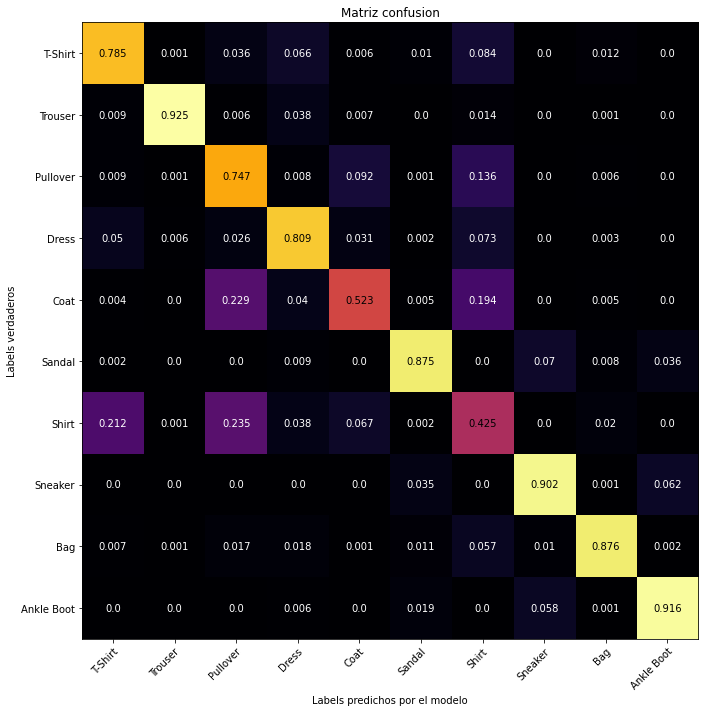

In [235]:
labels_names = [
    "T-Shirt",    # Remera manga corta
    "Trouser",    # Pantalon
    "Pullover",   # Buzo
    "Dress",      # Vestido
    "Coat",       # Abrigo
    "Sandal",     # Sandalia
    "Shirt",      # Remera manga larga
    "Sneaker",    # Zapatilla
    "Bag",        # Bolso
    "Ankle Boot", # Bota
]

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(confusion_matrix, cmap="inferno")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(labels_names)), labels=labels_names)
ax.set_yticks(np.arange(len(labels_names)), labels=labels_names)
ax.set_ylabel("Labels verdaderos")
ax.set_xlabel("Labels predichos por el modelo")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels_names)):
    for j in range(len(labels_names)):
        text_color = "black" if i == j else "w"
        text = ax.text(j, i, confusion_matrix[i, j]/1000, ha="center", va="center", color=text_color)

ax.set_title("Matriz confusion")
fig.tight_layout()

Text(0.5, 1.0, 'Precision en funcion de n')

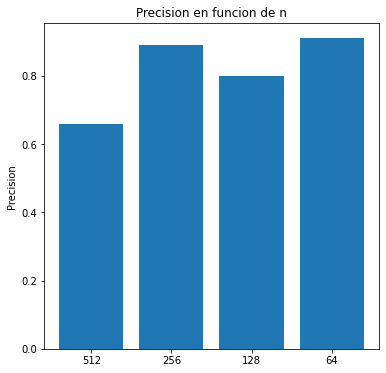

In [218]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2,3,4], [0.66, 0.89, 0.80, 0.91])
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["512","256","128","64"])
ax.set_ylabel("Precision")
ax.set_title("Precision en funcion de n")

Text(0, 0.5, 'Precision')

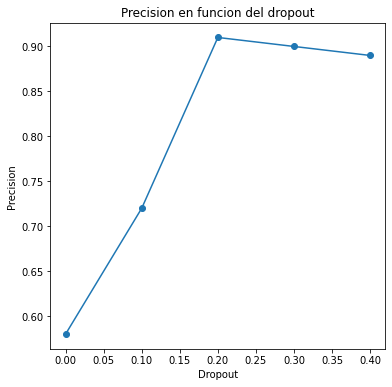

In [219]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0.0, 0.1, 0.2, 0.3, 0.4], [0.58, 0.72, 0.91, 0.90, 0.89])
ax.scatter([0.0, 0.1, 0.2, 0.3, 0.4], [0.58, 0.72, 0.91, 0.90, 0.89])
ax.set_title("Precision en funcion del dropout")
ax.set_xlabel("Dropout")
ax.set_ylabel("Precision")

Text(0, 0.5, 'Precision')

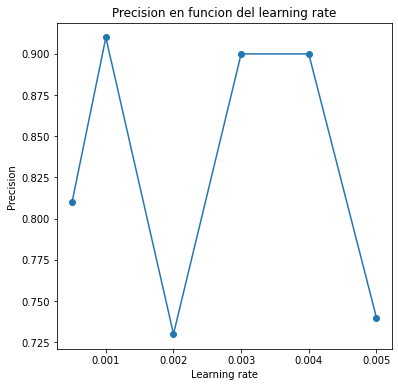

In [237]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([0.0005, 0.001, 0.002, 0.003, 0.004, 0.005], [0.81, 0.91, 0.73, 0.90, 0.90, 0.74])
ax.scatter([0.0005, 0.001, 0.002, 0.003, 0.004, 0.005], [0.81, 0.91, 0.73, 0.90, 0.90, 0.74])
ax.set_title("Precision en funcion del learning rate")
ax.set_xlabel("Learning rate")
ax.set_ylabel("Precision")

Text(0, 0.5, 'Precision')

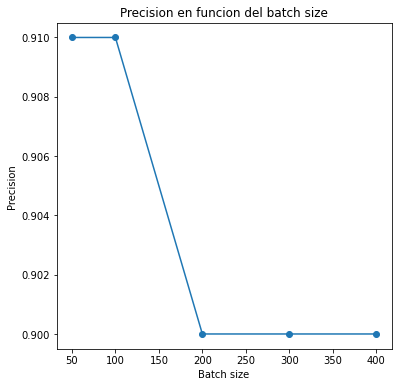

In [236]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot([50, 100, 200, 300,400], [0.91, 0.91, 0.90, 0.90, 0.90])
ax.scatter([50, 100, 200, 300, 400], [0.91, 0.91, 0.90, 0.90, 0.90])
ax.set_title("Precision en funcion del batch size")
ax.set_xlabel("Batch size")
ax.set_ylabel("Precision")

Text(0, 0.5, 'Precision')

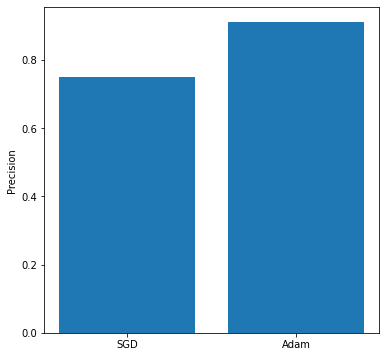

In [229]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar([1,2], [0.75, 0.91])
ax.set_xticks([1,2])
ax.set_xticklabels(["SGD","Adam"])
ax.set_ylabel("Precision")